# Lesson 9 Code Along

[Lesson 9 Wiki](http://forums.fast.ai/t/part-2-lesson-9-in-class/14028) | Notebook: [pascal-multi.ipynb](https://github.com/fastai/fastai/blob/master/courses/dl2/pascal-multi.ipynb)

---

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
torch.backends.cudnn.benchmark=True

## 1. Setup

In [4]:
PATH = Path('data/pascal')
trn_j = json.load((PATH / 'pascal_train2007.json').open())
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]]

JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS

In [5]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn_j[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
    return trn_anno

trn_anno = get_trn_anno()

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt, 
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [7]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
        
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

## 2. Multi Class

also check out [a quick pandas data processing pipeline](https://gist.github.com/binga/1bc4ebe5e41f670f5954d2ffa9d6c0ed), instead of using defaultdicts.

In [8]:
MC_CSV = PATH/'tmp/mc.csv'

In [9]:
trn_anno[12]

[(array([ 96, 155, 269, 350]), 7)]

In [10]:
mc = [set
      ([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

In [11]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [12]:
f_model=resnet34
sz=224
bs=64

In [13]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO)
md   = ImageClassifierData.from_csv(PATH, JPEGS, MC_CSV, tfms=tfms)

In [14]:
learn = ConvLearner.pretrained(f_model, md)
learn.opt_fn = optim.Adam

In [15]:
lrf = learn.lr_find(1e-5, 100)

epoch      trn_loss   val_loss   <lambda>                  
    0      1.398041   4.164995   0.849264  



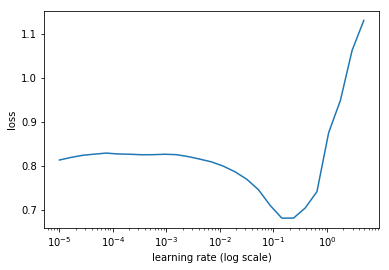

In [16]:
learn.sched.plot(0)

In [17]:
lr = 2e-2
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.323653   0.129685   0.957106  
    1      0.172651   0.078002   0.973122                  
    2      0.11537    0.075069   0.974707                  



[0.0750692025758326, 0.9747070446610451]

 84%|████████▍ | 27/32 [00:14<00:02,  1.84it/s, loss=0.51]  

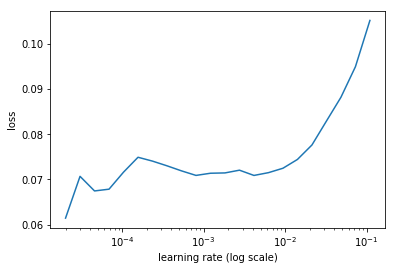

In [18]:
lrs = np.array([lr/100, lr/10, lr])
learn.freeze_to(-2)
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [19]:
learn.fit(lrs/10, 1, cycle_len=5, use_clr=(32,5))

 19%|█▉        | 6/32 [00:04<00:20,  1.27it/s, loss=0.076] 
epoch      trn_loss   val_loss   <lambda>                   
    0      0.072928   0.076492   0.974414  
    1      0.053138   0.078053   0.973881                   
    2      0.039226   0.075312   0.975947                   
    3      0.027348   0.076436   0.976187                   
    4      0.019412   0.075988   0.976164                   



[0.07598836394026875, 0.9761643558740616]

In [20]:
learn.save('mclas')

In [21]:
learn.load('mclas')

In [22]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


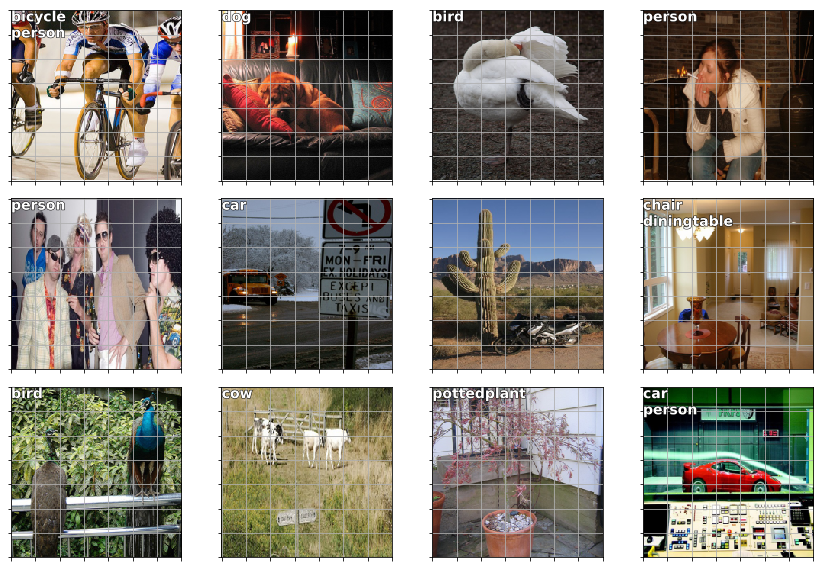

In [23]:
fig,axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    ya = np.nonzero(y[i] > 0.4)[0]
    b  = '\n'.join(md.classes[o] for o in ya)
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## 3. Bbox per Cell

### 3.1 Set up Data

In [8]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV  = PATH/'tmp/mbb.csv'

f_model = resnet34
sz = 224
bs = 64

In [9]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14]), ..., array([17,  8, 14, 14, 14]),
       array([6]), array([11])], dtype=object)

In [10]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [11]:
mbb  = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn', 'bbox'])
df.to_csv(MBB_CSV, index=False)

In [12]:
df.head()

fn                                               bbox
0  000012.jpg                                     96 155 269 350
1  000017.jpg                       61 184 198 278 77 89 335 402
2  000023.jpg  229 8 499 244 219 229 499 333 0 1 368 116 1 2 ...
3  000026.jpg                                     124 89 211 336
4  000032.jpg  77 103 182 374 87 132 122 196 179 194 228 212 ...

In [13]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD), 
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [14]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [15]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if ((b[2] > 0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i % num_colr])
            txt = f'{i}: '
            if c is not None:  txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i % num_colr])

In [16]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [17]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [18]:
x,y = to_np(next(iter(md.val_dl)))
x = md.val_ds.ds.denorm(x)

In [19]:
x,y = to_np(next(iter(md.trn_dl)))
x = md.trn_ds.ds.denorm(x)

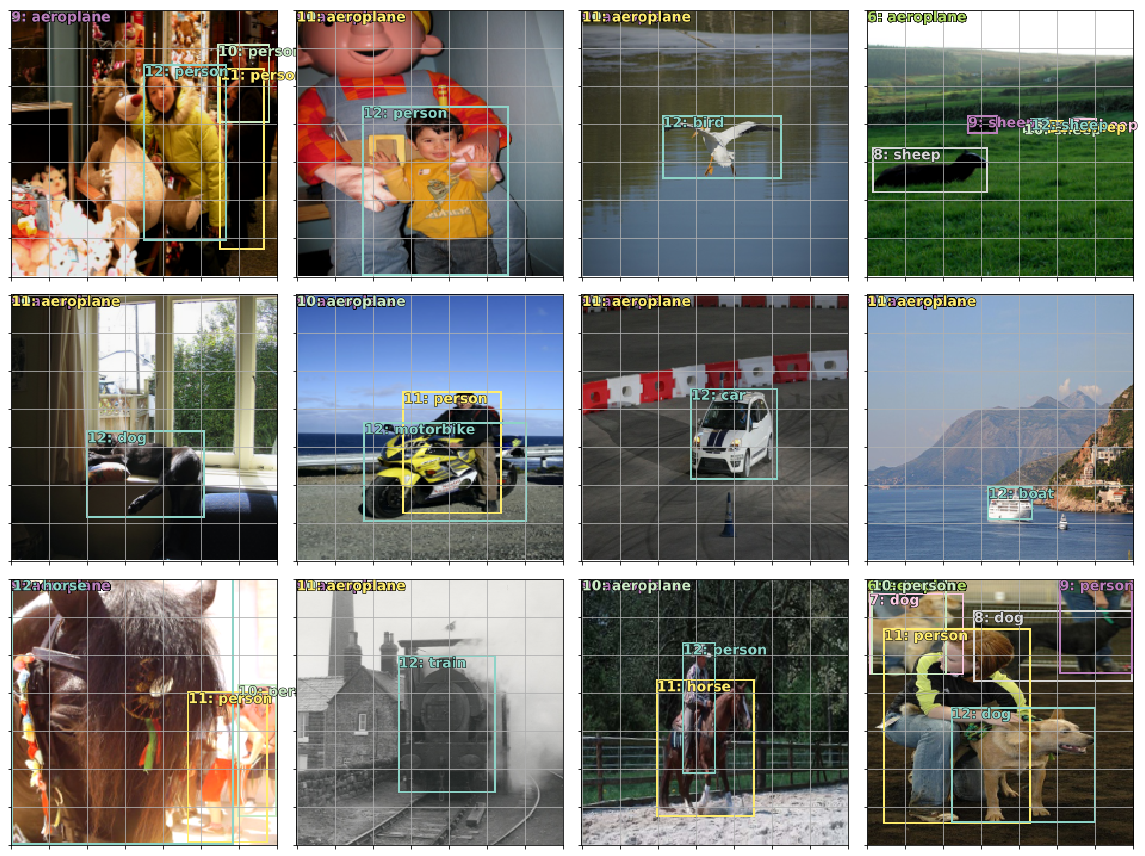

In [20]:
fig,axes = plt.subplots(3, 4, figsize=(16,12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

### 3.2 Set up Model

We're going to make a simple 1st model that simply predicts what object is located in each cell of a 4x4 grid. Later on we can try to improve this.

In [21]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs =  np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

In [22]:
grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

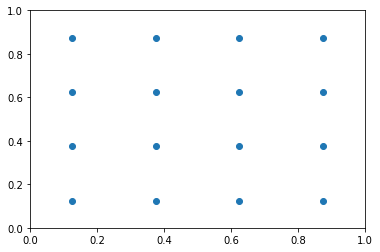

In [23]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [24]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [25]:
def hw2corners(ctr, hw): return torch.cat([ctr - hw/2, ctr + hw/2], dim=1)

In [26]:
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [27]:
n_clas = len(id2cat) + 1
n_act = k*(4 + n_clas)

In [28]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

In [29]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat) + 1)*k, 3, padding=1) # for classifier
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1) # for bounding box regression
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k), 
                flatten_conv(self.oconv2(x), self.k)]

In [30]:
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512, 256, stride=1)
        # self.sconv1 = StdConv(2556, 256)
        self.sconv2 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        # x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

In [31]:
head_reg4 = SSD_Head(k, -3.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
learn  = ConvLearner(md, models)
learn.opt_fn = optim.Adam
k

1

We start with stride 1 convolutions because it doesn't change the geometry at all - it lets us add an extra layer of convolutions. We have a mini NN in our custom head.

We have 2 conv layers, stride 1 then stride 2. The output of `self.sconv2 = StdConv(256, 256)` will be 4x4.

`OutConv` has 2 separate Conv layers, ea. of which is stride=1, so it's not changing the geometry of the input. 1 is of length: number of classes, the other is equal to 4. (k = 1 for now). So 2 Conv layers: 1 outputs 4, the other outputs C. We return them as a list of two items: two separate Tensors of actvns (classes and bbox coords).

That's *nearly* the same thing as having a single Conv layer that outputs 4+C; but it lets these layers specialize just a bit. Related tasks don't have to share *all* their layers.

We also add 1 to the classes Conv layer for background.

---

So again: we have our **Data**, we have our **Architecture**, now we just need our **Loss Function**.

The Loss Fn needs to look at each of these 16 sets of actvns (ea. of which will have 4 sets of bbx coords and C+1 class probs) and decide: are those actvns close/far away from the object closest to this grid cell in the image.

### 3.3 Train

**NOTE**: we don't *actually* use Cross Entropy. We use *Binary* Cross Entropy Loss for Classification here. We usually use BCE for multi-label classification (eg: Planet). Softmax can't be used for multi-label. In our case, each Anchor Box can only have 1 object associated with it, so the reason we can't use Softmax is it's possible for an Anchor Box to have *nothing* assoc. with it.

You could treat 'background' as a class and use Softmax. Lot's of people have done this. It's a very hard thing to ask a NN to do: "does this grid cell *not* have any of the 20 objects I'm interested in with a Jaccard overlap of 0.5?"

Instead you could ask the NN to go through each object and check "is it this? no.. is it this? no.." and if it's 'No' to all, then it's background.

---

To achieve this, in the `forward` method:

We take our target `targ` and do a One-Hot Embedding with the number of classes + 1: `one_hot_embedding(targ, self.num_classes + 1)`. At this stage we do have a class for background, but we remove that last column on the next line: `t = V(t[:,:-1].contiguous())`.

So now our vector `t` is either all zeros or there's 1 one.

Finally we use BCE to compare our predictions with that target: `F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes`

This is a minor tweak that makes a *major* difference to training. Also when new ML papers are published: it's usually for some new tweak like this.

In [32]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes + 1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self, x, t): return None

In [33]:
loss_f = BCE_Loss(len(id2cat))

Here we calculate the Jaccard Index, the Intesection Over Union:

In [34]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

The way we interpret the activations is important. We do that with `actn_to_bb`. We grab the activations; stick them through tanh (tanh is the same as Sigmoid but scaled between -1:1) which forces them to be in our range; then we grab the actual position of the anchor boxes (`+ anchors[:,:2]`) and move them around according to the value of the activations divided by 2: `(actn_bbs[:,:2]/2 *grid_sizes)` -- so ea. predictive BB can be moved by up to 50% of a grid size from its default position. Likewise for it's height & width: it can be scaled between 0.5x to 2x from default size.

In [35]:
def get_y(bbox, clas):
    bbox = bbox.view(-1, 4)/sz
    bb_keep = ((bbox[:, 2] - bbox[:, 0]) > 0).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2 + 1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
    #pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred, targ, print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

We have our custom loss fn (BCE+), the calc for Jacc.Idx, the activations-to-bbox converter, the ground-truth-mapper, and the last thing left is our SSD Loss Function. This is what we set as our criterion below (`learn.crit = ssd_loss`).

`ssd_loss` loops through ea. image in the minibatch, and calls `ssd_1_loss` on it (SSD Loss for 1 image).

`ssd_1_loss` first destructures bounding boxes & classes, & removes their padding. The Fast.ai Library automatically pads the input data with zeros (bc there can be dfrnt numbers of Ground Truth Objects in each image, but a Tensor must strictly be of a rectangular shape). This allows for parallel batched processing; but you *must* remember to strip off the padding zeros, and this is what `get_y` does on the line: `bb_keep = ((bbox[:,2] - bbox[:,0]) > 0).nonzero()[:,0]` (removes all padding-bounding-boxes).

`ssd_1_loss` then converts activations to bounding boxes via `a_ic = actn_to_bb(..)`; calculates the Jacc., get overlaps and Ground Truth, check for overlap over some threshold (0.4 here), find what matches (`pos_idx = ..`), get the background classes for those that don't, and finally get the L1 loss for the Localization part, and the BCE Loss for the Classification part, and return those 2 pieces.

Then `ssd_loss` takes the two pieces and adds them together: `return lls+lcs` $\longleftarrow$ Loss:Localizations + Loss:Classifications.

In [248]:
x,y = next(iter(md.val_dl))
# x,y = V(x).cpu(),V(y)
x,y = V(x),V(y)

In [249]:
# for i,o in enumerate(y): y[i] = o.cpu()
# learn.model.cpu()

In [250]:
batch = learn.model(x)

In [251]:
# anchors = anchors.cpu()
# grid_sizes = grid_sizes.cpu()
# anchor_cnr = anchor_cnr.cpu()

In [252]:
ssd_loss(batch, y, True)


 0.1947
 0.1168
 0.2652
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.2885
 0.0888
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.9027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.1608
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3237
 0.2153
 0.2558
 0.2013
 0.2526
 0.0485
 0.0879
[torch.cuda.FloatTensor of size 7 (GPU 0)]


 0.3258
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2704
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3985
 0.4538
 0.1897
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.1527
 0.1863
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.3426
 0.3249
 0.5062
[torch.cuda.FloatTensor of size 3 (GPU 0)]


 0.0642
 0.2506
[torch.cuda.FloatTensor of size 2 (GPU 0)]


 0.2027
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.2418
 0.2337
 0.2590
[torch.cuda.FloatTensor of size 3 (GPU 0)]


1.00000e-02 *
  8.4642
[torch.cuda.FloatTensor of size 1 (GPU 0)]


 0.3652
 0.1377
[torch.cuda.FloatTensor of size 2 (GPU 0)]


1.00000e-02 *
  9.5146
  5.739

Variable containing:
 83.2305
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Now with our **Data**, **Architecture**, and **Loss Function** we have the 3 things we need to train:

In [253]:
learn.crit = ssd_loss
lr = 3e-3
lrs = np.array([lr/100,lr/10,lr])

epoch      trn_loss   val_loss                            
    0      135.3587   319618.251953



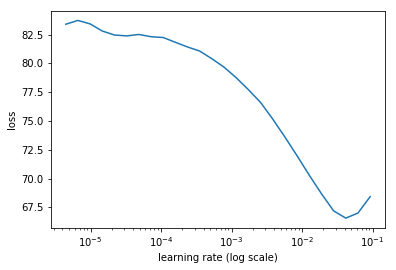

In [254]:
learn.lr_find(lrs/1000,1.)
learn.sched.plot(1)

In [255]:
learn.fit(lr, 1, cycle_len=5, use_clr=(20,10))

epoch      trn_loss   val_loss                            
    0      42.802824  31.616288 
    1      33.634386  28.359744                           
    2      29.369969  26.998438                           
    3      26.563668  26.304111                           
    4      24.498     25.733856                           



[25.733855962753296]

In [256]:
learn.save('0')

In [32]:
learn.load('0')

### 3.4 Testing

Grab our validation set data loader; grab a batch from it; turn them into variables - so we can put them in model; set our model to evaluation mode; stick that data into our model to grab a batch of activations.

The final output Convolution returned 2 items: the classes and the bounding boxes -- so we can do destructuring assignment to grab the 2 pieces (the batch of classes outputs, and the batch of bounding box outputs).

In [37]:
x,y = next(iter(md.val_dl))
x,y = V(x),V(y)
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

As expected the batch of class outputs is batch size 64 by 16 grid cells by 21 classes; and 64x16x4 for the bounding box coordinates.

In [259]:
b_clas.size(),b_bb.size()

(torch.Size([64, 16, 21]), torch.Size([64, 16, 4]))

Going back to look at the ground truth in the `y` variable; grab the bounding box and class parts and put them into 2 python variables to print them:

In [260]:
idx = 7
b_clasi = b_clas[idx]
b_bboxi = b_bb[idx]
ima = md.val_ds.ds.denorm(to_np(x))[idx]
bbox,clas = get_y(y[0][idx], y[1][idx])
bbox,clas

(Variable containing:
  0.6786  0.4866  0.9911  0.6250
  0.7098  0.0848  0.9911  0.5491
  0.5134  0.8304  0.6696  0.9063
 [torch.cuda.FloatTensor of size 3x4 (GPU 0)], Variable containing:
   8
  10
  17
 [torch.cuda.LongTensor of size 3 (GPU 0)])

We see our groundtruth bounding boxes and groundtruth classes -- this image apparently has 3 objects in it. So let's draw the image of these 3 objects:

In [263]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
                to_np(clas), to_np(prs) if prs is not None else None, thresh)

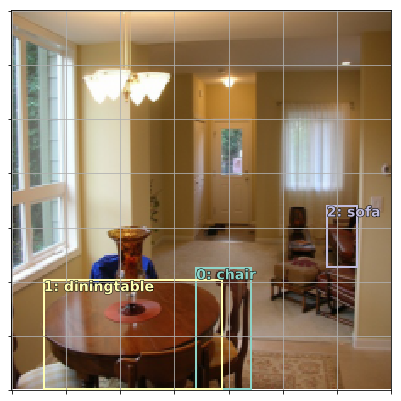

In [264]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

Here are our 4x4 grid cells from our final Conv layer. The boxes are called **Anchor**/Prior/Default boxes.

What we're going to do for this LossFn is we're going to go through a matching-problem, where we're going to take ea. one of these 16 boxes and see which one of the 3 ground-truth objects has the highest amount of overlap with it.

So we need some way of measuring overlap. The **Jaccard Index** is the standard fn used for this. It's the area of the Intersection of the Anchor Box (AB) and Ground Truth Box/Object (GTO) divided by the area of their Union. $\longrightarrow$ IOU: Intersection Over Union.

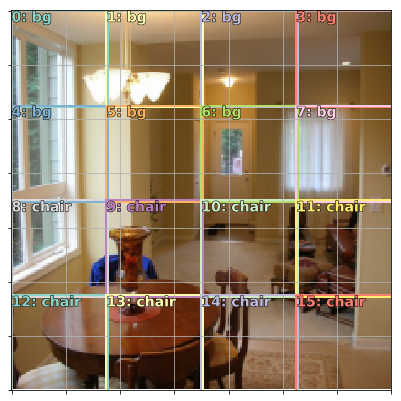

In [265]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

In [266]:
grid_sizes

Variable containing:
 0.2500
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]

So we'll find the Jaccard overlap for each of our objects vs ea. of the 16 ABs, giving us a 3 x 16 matrix.

Here are the coordinates of ea. of our ABs, printed as Center (X,Y), Height, Width

In [267]:
anchors

Variable containing:
 0.1250  0.1250  0.2500  0.2500
 0.1250  0.3750  0.2500  0.2500
 0.1250  0.6250  0.2500  0.2500
 0.1250  0.8750  0.2500  0.2500
 0.3750  0.1250  0.2500  0.2500
 0.3750  0.3750  0.2500  0.2500
 0.3750  0.6250  0.2500  0.2500
 0.3750  0.8750  0.2500  0.2500
 0.6250  0.1250  0.2500  0.2500
 0.6250  0.3750  0.2500  0.2500
 0.6250  0.6250  0.2500  0.2500
 0.6250  0.8750  0.2500  0.2500
 0.8750  0.1250  0.2500  0.2500
 0.8750  0.3750  0.2500  0.2500
 0.8750  0.6250  0.2500  0.2500
 0.8750  0.8750  0.2500  0.2500
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [268]:
a_ic = actn_to_bb(b_bboxi, anchors)

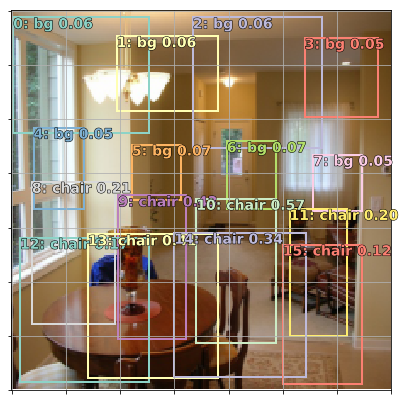

In [269]:
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], 
         b_clasi.max(1)[0].sigmoid(), thresh=0.0)

As you can see: the 3x16 matrix of IOU (Jaccard) overlaps for each AB & GTO. Here you can see the 8th AB overlaps a little bit with the 2nd GTO

In [270]:
overlaps = jaccard(bbox.data, anchor_cnr.data)
overlaps



Columns 0 to 9 
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0091
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0356  0.0549
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 10 to 15 
 0.0922  0.0000  0.0000  0.0315  0.3985  0.0000
 0.0103  0.0000  0.2598  0.4538  0.0653  0.0000
 0.0000  0.1897  0.0000  0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 3x16 (GPU 0)]

What we can do now is take the max of each row (max of dimension 1), and that'll tell us: foreach GTO what's the max amount of overlap with any gridcell.

PyTorch returns the max and it's index when you ask for `.max`; so we also have their indices.

This gives us a pretty good way of assigning ea. of these GTOs to a gridcell -- matching to highest overlap.

In [271]:
overlaps.max(1)

(
  0.3985
  0.4538
  0.1897
 [torch.cuda.FloatTensor of size 3 (GPU 0)], 
  14
  13
  11
 [torch.cuda.LongTensor of size 3 (GPU 0)])

We also look at the max over dim 0, which tells us the max amount of overlap foreach gridcell across each of the GTOs.

The indices tell us for every gridcell (16): what's the index of the GTO that overlaps with it the most.

'0' is overloaded: it could either mean no overlap, or object idx 0 overlaps -- but it turns out not to matter (bc we set '0' to be the background).

In [272]:
overlaps.max(0)

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  0.1897
  0.2598
  0.4538
  0.3985
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

`map_to_ground_truth` combines the 2 sets of overlaps (along GTO, along gridcell) in a way described by the SSD paper to assign each AB to a GTO. GTOs are assigned to their highest overlapping AB. All other ABs are assigned to the GTO to which their overlap is > 0.5. All others are considered to be cells containing background.

Below you see in the 2nd list the assignments; in the 1st any number < 0.5 is bg; the 'forced' assignments are given a high number to make sure they get assigned.

In [273]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)
gt_overlap,gt_idx

(
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0000
  0.0356
  0.0549
  0.0922
  1.9900
  0.2598
  1.9900
  1.9900
  0.0000
 [torch.cuda.FloatTensor of size 16 (GPU 0)], 
  0
  0
  0
  0
  0
  0
  0
  0
  1
  1
  0
  2
  1
  1
  0
  0
 [torch.cuda.LongTensor of size 16 (GPU 0)])

So now we can convert them to classes:

In [274]:
gt_clas = clas[gt_idx]; gt_clas

Variable containing:
  8
  8
  8
  8
  8
  8
  8
  8
 10
 10
  8
 17
 10
 10
  8
  8
[torch.cuda.LongTensor of size 16 (GPU 0)]

And using a threshold on 0.5 let's us see the 3 classes that are being predicted;

In [275]:
thresh = 0.5
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:,0]
neg_idx = torch.nonzero(1-pos)[:,0]
pos_idx


 11
 13
 14
[torch.cuda.LongTensor of size 3 (GPU 0)]

And we can use that to see what class each AB is meant to be predicting.

In [276]:
gt_clas[1-pos] = len(id2cat)
[id2cat[o] if o < len(id2cat) else 'bg' for o in gt_clas.data]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'sofa',
 'bg',
 'diningtable',
 'chair',
 'bg']

So That's the matching stage.

---

Once we're done with matching, we're p.much finished. We can take the activations which matched something, subtract from those the GT bounding boxes, take the Absolute Value of the Difference, the Mean of that: and that's L1Loss.

For the Classifications we can do Cross Entropy. (We ultimately add them both for our full Loss Function)

In [277]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
clas_loss = F.cross_entropy(b_clasi, gt_clas)
loc_loss,clas_loss

(Variable containing:
 1.00000e-02 *
   7.5432
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  1.1404
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


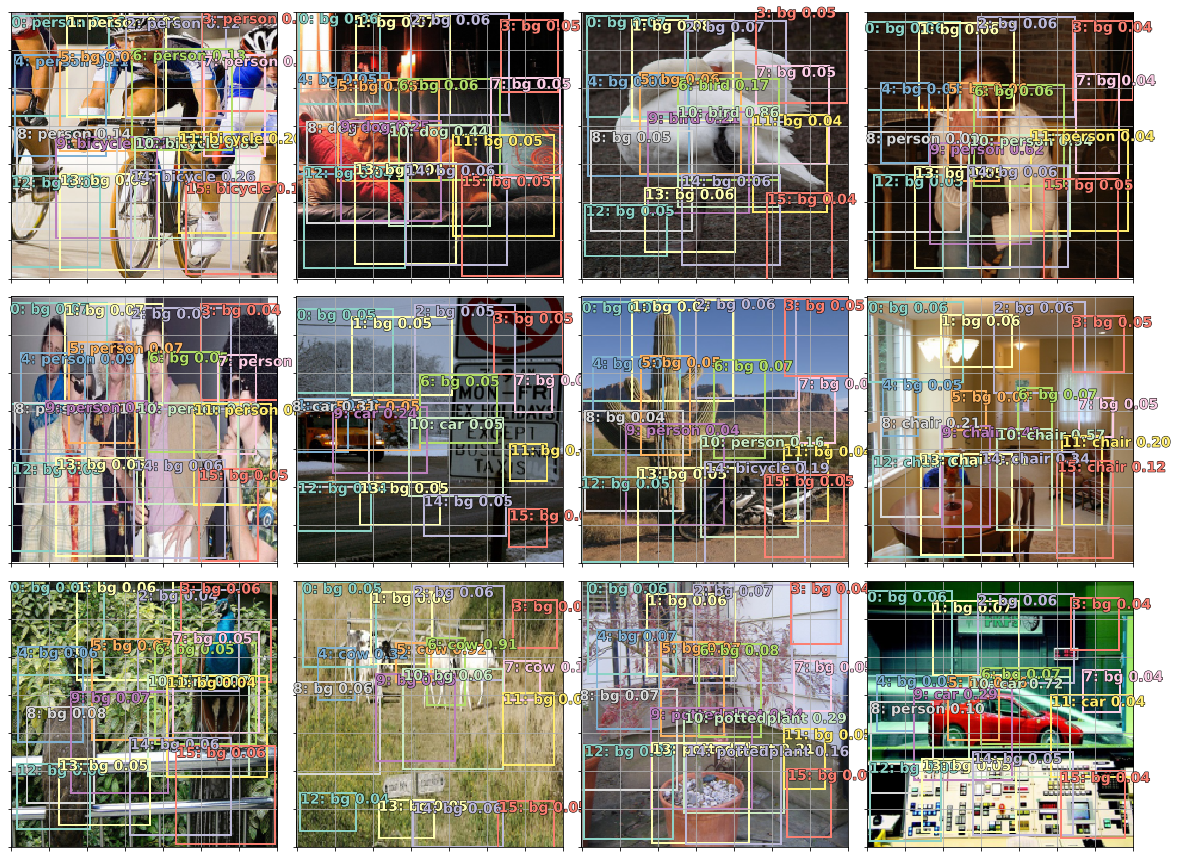

In [279]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for idx,ax in enumerate(axes.flat):
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    ima = md.val_ds.ds.denorm(to_np(x))[idx]
    bbox,clas = get_y(bbox,clas); bbox,clas
    a_ic = actn_to_bb(b_bb[idx], anchors)
    torch_gt(ax, ima, a_ic, b_clas[idx].max(1)[1], b_clas[idx].max(1)[0].sigmoid(), 0.01)
plt.tight_layout()

In practice we'd remove the background, but you can see it's kind of working in the right direction. It sees the bird in the middle with a 0.86, the car, etc. It doesn't pick up the motorcycle (calls it a bicycle), it barely sees the potted plant; and that's bc our ABs are too few: we just have a 4x4 grid. We'll solve this by just having many more of them.

## 4. More Anchors

There're 3 ways to make more anchor boxes.

1. Create different ABs of dfrnt sizes and aspect ratios.

2. Use more Conv layers as sources of bounding boxes.

### 4.1 Create Anchors

In [74]:
# anc_grids = [4,2,1]
anc_grids = [2]
# anc_zooms = [0.7, 1., 1.3]
anc_zooms = [1.]
# anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

1

In [75]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag) 
                       for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag) 
                       for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [76]:
anc_sizes  =  np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) 
                                        for o,p in anchor_scales])
                              for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([1/ag       for i in range(ag*ag) 
                                        for o,p in anchor_scales])
                              for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors    = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [77]:
# anchors

In [78]:
x,y = to_np(next(iter(md.val_dl)))
x   = md.val_ds.ds.denorm(x)

In [79]:
a = np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

Using:
```
anc_grids = [2]
anc_zooms = [1.]
anc_ratios = [(1.,1.)]
```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


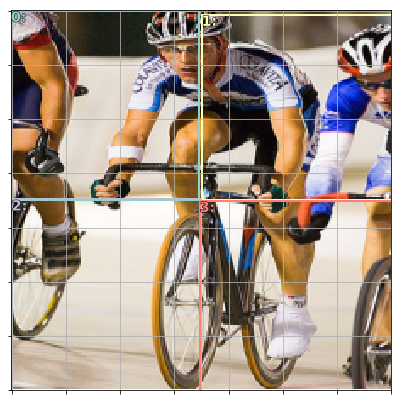

In [80]:
fig,ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

Using:
```
anc_grids = [2]
anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
```

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


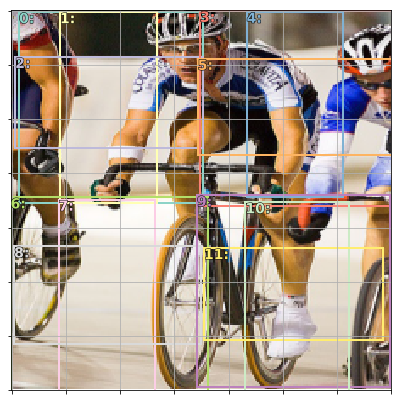

In [73]:
fig,ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, x[0], a)

### temp